# GEOG 5160 6160 Lab 09

Let's begin by importing the packages we'll need for the lab:

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
## Set random seed for reproducibility
np.random.seed(1234)

## Regression neural networks

We'll start with an example of using a neural network for a regression task. The data are taken from a Kaggle competition and are based on a set of 77 breakfast cereals. A description of the data is given in the appendix. The last field in the file (`rating`) is the outcome variable that we will build the network for. Start by reading the file:

In [2]:
cereal = pd.read_csv("../datafiles/cereals.csv")
print(cereal.shape)

(77, 16)


In [3]:
cereal.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25.0,3,1.0,0.33,68.40
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0.0,3,1.0,1.00,33.98
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25.0,3,1.0,0.33,59.43
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25.0,3,1.0,0.50,93.70
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25.0,3,1.0,0.75,34.38


Next, we'll select a subset of the numeric features for modeling, as well as the outcome variable. We can use this to plot a correlation matrix showing the correlation between each variable (including the outcome `rating`)

In [4]:
cereal = cereal[['rating','calories','protein','fat','sodium','fiber']]

<AxesSubplot:>

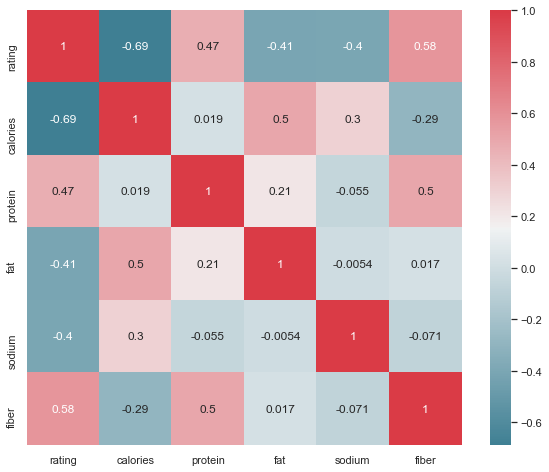

In [5]:
f, ax = plt.subplots(figsize=(10, 8))
corr = cereal.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot = True)

### Linear model

We'll start by making a linear model as a baseline for comparisons with the neural network. First, we'll make up the set of features and labels, and then split these into two for simple hold-out based cross-validation

In [6]:
from sklearn.model_selection import train_test_split

X = cereal[['calories','protein','fat','sodium','fiber']]
y = cereal['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.8)

In [7]:
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)
print(np.round(lin_reg.score(X_train, y_train), 3))

0.824


This is a reasonable model with an R$^2$ of about 0.8. Now, we can test it's predictive skill by calculating the root mean squared error (RMSE)

In [8]:
y_test_pred = lin_reg.predict(X_test)
from sklearn.metrics import mean_squared_error
print('Root mean squared error: %.2f'
      % mean_squared_error(y_test, y_test_pred, squared = False))

Root mean squared error: 5.29


And we can further to check the RMSE through a five-fold cross-validation, to give us a baseline score for comparison to the neural network.

In [9]:
from sklearn.model_selection import cross_val_score, KFold
# define model evaluation method
cv = KFold(n_splits=5)

scores = cross_val_score(lin_reg, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')
print("%.3f" % np.mean(-scores))

6.473


### Neural network

Now we'll turn to making a neural network. We'll again use scikit-learn to build the network. As the network uses weighted sums of the input features, it's important that none of these are on very different scales. The easiest way to avoid this is to scale all variables to approximately the same range. The scaling we use here is a min-max transformation or *normalization* (i.e. each variable is converted to a 0-1 range). This transformation is given by the following equation. 

$x_i'=\frac{x_i-min(x)}{max(x)-min(x)}$

To calculate this, we'll take advantage of some Pandas functions here that calculate the minimum and maximum of each column:  

In [10]:
X_normalized = (X - X.min()) / (X.max() - X.min())

To check this has worked, let's look at the min and max values for each column in the new DataFrame:

In [11]:
print(X_normalized.min())
print(X_normalized.max())

calories    0.0
protein     0.0
fat         0.0
sodium      0.0
fiber       0.0
dtype: float64
calories    1.0
protein     1.0
fat         1.0
sodium      1.0
fiber       1.0
dtype: float64


Now let's re-create our training and testing set

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y,
                                                    train_size = 0.8)

We can now fit the network. For a regression neural network, we need the `MLPRegressor` function from the `neural_network` submodule. There are (as ever) a lot of parameters that you can tweak. A few key ones are :

- `hidden_layer_sizes`: this defines the size (and number) of hidden layers. 
- `activation`: The activation function. For this first attempt, we'll use a sigmoid function (`logistic`)
- `solver`: the optimization method. We'll use `lbfgs` here, as it works well with small datasets. Two alternatives are `adam`, which is recommended for large datasets, and a stochastic gradient descent `sgd`. This latter solver is a powerful method, but in general requries a fair amount of tuning to get the best performance.

In [13]:
from sklearn.neural_network import MLPRegressor

nn_reg = MLPRegressor(hidden_layer_sizes=(3,),  
                      activation='logistic', 
                      solver='lbfgs', 
                      max_iter = 200)

Let's fit this to our testing dataset:

In [14]:
nn_reg.fit(X_train, y_train)

/opt/miniconda3/envs/geog5160/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(activation='logistic', hidden_layer_sizes=(3,), solver='lbfgs')

You should see a warning message telling you that the algorithm did not converge before reaching the maximum number of iterations. This is quite a difficult dataset to model, as there are a low number of observations. Let's calculate the RMSE to see how far off this model is:

In [15]:
y_test_pred = nn_reg.predict(X_test)
print('Root mean squared error: %.2f'
      % mean_squared_error(y_test, y_test_pred, squared = False))

Root mean squared error: 11.42


Almost twice as bad as the simple linear regression. Let's first try increasing the iteration limit and see if it will fit:

In [16]:
nn_reg = MLPRegressor(hidden_layer_sizes=(3,),  
                      activation='logistic', 
                      solver='lbfgs', 
                      max_iter = 500,
                     random_state = 1)
nn_reg.fit(X_train, y_train)
y_test_pred = nn_reg.predict(X_test)
print('Root mean squared error: %.2f'
      % mean_squared_error(y_test, y_test_pred, squared = False))

Root mean squared error: 10.67


500 iterations is enough to get the model to converge, but the error is still pretty high. 

Before making a further additions, we can visualize the network we have obtained. This is an optional section, and if you want to get it to run, you will need to down load the file *VisualizeNN.py* and copy it to your working directory. The script works in two steps: first it extracts the network structure and connection weights and then we use the `DrawNN()` method to plot it. 

In [17]:
import VisualizeNN as VisNN
#network_structure = np.hstack(([X_train.shape[1]], 
#                               np.asarray(nn_reg.hidden_layer_sizes), 
#                               [y_train.shape[1]]))
network_structure = np.hstack(([X_train.shape[1]], 
                               np.asarray(nn_reg.hidden_layer_sizes), 
                               [1]))

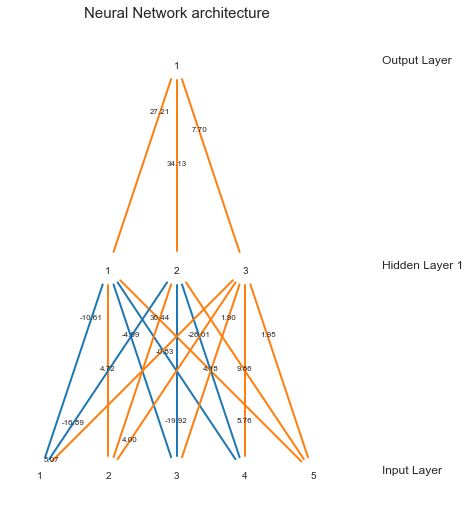

In [18]:
network=VisNN.DrawNN(network_structure, nn_reg.coefs_)
network.draw()

Let's try to improve on this model. One key parameter in a multi-layer neural network is the definition of the hidden layers, which include

- the number of layers
- the number of nodes in each layer

A good rule of thumb for the number of nodes is that this should be somewhere between the number of input and number of output nodes. However, picking this number is not straightforward. Another good suggestion is that you should generally prefer a smaller number of nodes, but a larger number of layers. 

We'll now see if adding a second hidden layer will improve the model. To do this, we simply add another value to the `hidden_layer_sizes` argument. This is a tuple containing a set of integer values. The length of the tuple is the number of hidden layers, and the individual values define how many nodes to include in that layer. Here, we use two hidden layers, with 6 and 3 nodes respectively. As the network is more complex, we'll increase the number of iterations to make sure it converges:

In [19]:
nn_reg = MLPRegressor(hidden_layer_sizes=(6,3),  
                      activation='logistic', 
                      solver='lbfgs', 
                      max_iter = 5000,
                     random_state = 1)
nn_reg.fit(X_train, y_train)
y_test_pred = nn_reg.predict(X_test)
print('Root mean squared error: %.2f'
      % mean_squared_error(y_test, y_test_pred, squared = False))

Root mean squared error: 7.02


/opt/miniconda3/envs/geog5160/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Even with the larger number of iterations, this still fails to converge. But despite this, we get a fairly large improvement in the RMSE. 

The last thing we can try is to change the solver. We'll use the stochastic gradient descent, with a couple of hyperparameters that control the learning rate. The values shown here were obtained through trial and error, but a better approach would be to use a grid search of potential values (try changing these to see the effect). We'll also try a different activation function: `relu` 

In [20]:
nn_reg = MLPRegressor(hidden_layer_sizes=(100,),
                      activation='relu',
                      solver='sgd', 
                      max_iter=10000, 
                      random_state=1, 
                      learning_rate_init=0.01,
                      momentum = 0.6,
                      tol=1e-4)
nn_reg.fit(X_train, y_train)
y_test_pred = nn_reg.predict(X_test)
print('Root mean squared error: %.2f'
      % mean_squared_error(y_test, y_test_pred, squared = False))

Root mean squared error: 5.89


Stochastic descent algorithms (like `sgd` and `adam`) will output a loss curve, showing the reduction in the overall loss as the network trains. You can visualize this as follows:

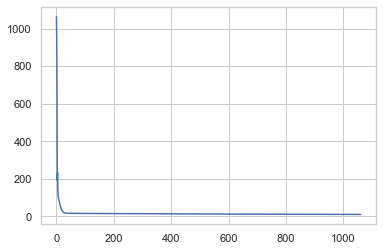

In [21]:
plt.plot(nn_reg.loss_curve_)
plt.show()

Finally, we can use the $k$-fold cross-validation strategy defined above to see what the overall prediction error is:

In [22]:
from sklearn.model_selection import cross_val_score, KFold
# define model evaluation method
cv = KFold(n_splits=5)

scores = cross_val_score(nn_reg, X_normalized, y, cv=cv, scoring = 'neg_root_mean_squared_error')

In [23]:
with np.printoptions(precision=3, suppress=True):
    print(scores)
print("%.3f" % np.mean(-scores))

[-6.07  -6.562 -5.411 -6.284 -7.608]
6.387


This gives us a slight improvement over the simple linear model. 

## Classification neural networks

Next, we'll build a neural network for a classification task. We'll use a new dataset, containing credit rankings for over 4000 people (see appendix for a description of the fields). The goal will be to predict `Status`, a binary outcome with two levels: `good` and `bad`. We'll start again by reading the data:

In [24]:
credit = pd.read_csv("../datafiles/credit_data.csv")
print(credit.shape)

(4454, 14)


If we take a look at the first few rows of the data, you should see that there are a mixture of numerical and categorical variables, as well as a range of different scales for the numerical variables. 

In [25]:
credit.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,good,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,good,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,bad,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,good,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,good,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910


In addition, if you run the `isna()` method, you'll see that there are missing values in several of the features. As machine learning algorithms can't use missing data to train, we need to decide what to do with these missing values. 

In [26]:
credit.isna().any()

Status       False
Seniority    False
Home          True
Time         False
Age          False
Marital       True
Records      False
Job           True
Expenses     False
Income        True
Assets        True
Debt          True
Amount       False
Price        False
dtype: bool

There are several steps that we might want to do to process these data:

- Impute any missing values
- Convert categorical/factor variables to numeric by one-hot encoding
- Scale the numerical variables to prevent biases while training our neural networks

While it is possible to do this in an ad-hoc way (as we did in the previous example), we will set up a processing *pipeline* that contains all of these steps. This takes more time to set up, but has a number of advantages: we can use the pipeline directly in cross-validation or tuning, and we can use it to process any new data that we might to make predictions for, without having to remember the individual steps. scikit-learn has a whole series of submodules and functions to help with this process, and we'll look at some of these here. Full details, including a number of worked examples, can be found on the scikit-learn website here: https://scikit-learn.org/stable/data_transforms.html

Let's start by splitting the data into a training and testing set using a simple holdout (we'll use this to demonstrate some of the functions:

In [27]:
X = credit.loc[:, credit.columns != 'Status']
y = credit['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.8)

It is possible to set up the full pipeline in one step, but we'll work through this gradually so you can get a sense of what each operator is doing. As we have mixed data (numeric and categorical), we'll need separate operators for each type. You can get a list of the data types in a Pandas DataFrame by looking at the `dtypes` property:

In [28]:
X.dtypes

Seniority      int64
Home          object
Time           int64
Age            int64
Marital       object
Records       object
Job           object
Expenses       int64
Income       float64
Assets       float64
Debt         float64
Amount         int64
Price          int64
dtype: object

It is possible to set up the full pipeline in one step, but we'll work through this gradually so you can get a sense of what each operator is doing. As we have mixed data (numeric and categorical), we'll need separate operators for each type. We'll start by setting up lists containing the names of the categorical and numerical types so that we can refer to these for each step. 

In [29]:
categorical_features = ['Home', 'Marital', 'Records', 'Job']
numerical_features = ['Seniority', 'Time', 'Age', 'Expenses', 'Income', 
                      'Assets', 'Debt', 'Amount', 'Price']

Next, we'll design two operators to process the categorical data. The first will carry out a mode-based imputation of any missing values (i.e. fill in with the most common value). This is a simple (single) imputation method, and we need the `SimpleImputer()` function from `sklearn.impute`. Note that we include an argument `strategy` to define what value we will use to fill in the missing values. 

In [30]:
from sklearn.impute import SimpleImputer
imp_cat = SimpleImputer(strategy="most_frequent")

Having set this up, we can run it on our data. This can be done using the `fit()` method, which 'fits' an imputation method to a given dataset. While this is not a machine learning method, we are still building a simple model - here just finding the most common value in each column. Note that we use the vector of column names to confine this operation to the categorical features.

In [31]:
imp_cat.fit(X[categorical_features])

SimpleImputer(strategy='most_frequent')

To actually see the results of this, we can use the `fit_transform()` method to output the results as an array

In [32]:
X_impute = imp_cat.fit_transform(X[categorical_features])
print(X_impute)

[['rent' 'married' 'no' 'freelance']
 ['rent' 'widow' 'no' 'fixed']
 ['owner' 'married' 'yes' 'freelance']
 ...
 ['owner' 'married' 'no' 'partime']
 ['rent' 'single' 'no' 'freelance']
 ['owner' 'married' 'no' 'freelance']]


To check that this has, in fact, filled the missing values, we can convert this array to a DataFrame and reuse the code to check for the presence of missing values:

In [33]:
X_impute_df = pd.DataFrame(X_impute, columns = categorical_features)
X_impute_df.isna().any()

Home       False
Marital    False
Records    False
Job        False
dtype: bool

Next, we'll one-hot encode the categorical variables. This converts each feature to a new set of numerical, integer features, one per level in the original feature. So a column titled 'sex', containing the levels 'female' and 'male' would be converted to two new columns: 'sex_female' and 'sex_male'. Each new column has a simple binary representation of that level, so an observation coded as 'female' would have 'sex_female' = 1 and 'sex_male' = 0. For this we need the `OneHotEncoder` function from `preprocessing`. Note that we include the argument `drop = 'first'`. This will remove the first new encoded feature to reduce redundancy and multicollinearity. 

In [34]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop = 'first')
ohe.fit(X[categorical_features])

OneHotEncoder(drop='first')

Output is as a sparse matrix by default, so to visualize what it is doing, we can covert to a NumPy array

In [35]:
X_cat = ohe.transform(X[categorical_features]).toarray()
X_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

Now we have the two operations for the categorical features, we can combine them into a pipeline. The function you need is, amazingly, called `Pipeline()`. This requires the argument `steps`, which is a list of all the individual operators. We'll include the two that we have already defined, but note that you could define these directly in the pipeline if needed. 

In [36]:
from sklearn.pipeline import Pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', imp_cat),
    ('encoder', ohe)])

We can visualize the pipeline by importing `set_config`, and changing the display type. You can now just type the name of the pipeline to see the following diagram:

In [37]:
from sklearn import set_config
set_config(display='diagram')
categorical_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(drop='first'))])

Now let's do the same thing for the numerical variables. We'll start by imputing the median value. This again uses the `SimpleImputer` but with a different strategy:

In [38]:
from sklearn.impute import SimpleImputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='median')
print(imp_num.fit_transform(X[numerical_features]))

[[   9.   60.   30. ...    0.  800.  846.]
 [  17.   60.   58. ...    0. 1000. 1658.]
 [  10.   36.   46. ...    0. 2000. 2985.]
 ...
 [   0.   24.   37. ...    0.  500.  963.]
 [   0.   48.   23. ...    0.  550.  550.]
 [   5.   60.   32. ... 1000. 1350. 1650.]]


Quick check to see that all the NaNs have been removed:

In [39]:
X_impute_df = pd.DataFrame(imp_num.fit_transform(X[numerical_features]), 
                           columns = numerical_features)
X_impute_df.isna().any()

Seniority    False
Time         False
Age          False
Expenses     False
Income       False
Assets       False
Debt         False
Amount       False
Price        False
dtype: bool

Next, we'll rescale the numerical values to a 0-1 range using `MinMaxScaler`. The default range is 0-1, but this can be adjusted if you want a different range. 

In [40]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
X_scale_df = pd.DataFrame(scale.fit_transform(X[numerical_features]), 
                           columns = numerical_features)
X_scale_df.describe()

,Seniority,Time,Age,Expenses,Income,Assets,Debt,Amount,Price
count,4454.000000,4454.000000,4454.000000,4454.000000,4073.000000,4407.000000,4436.000000,4454.000000,4454.000000
mean,0.166391,0.612708,0.381608,0.141886,0.142380,0.018013,0.011434,0.191616,0.123043
std,0.170298,0.222052,0.219692,0.134591,0.084731,0.038581,0.041533,0.096846,0.056921
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.041667,0.454545,0.200000,0.000000,0.088143,0.000000,0.000000,0.122449,0.091731
50%,0.104167,0.636364,0.360000,0.110345,0.124869,0.010000,0.000000,0.183673,0.117354
75%,0.250000,0.818182,0.540000,0.255172,0.172088,0.020000,0.000000,0.244898,0.143770
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


And we can now arrange these two operations in a pipeline for the numerical features. 

In [41]:
numerical_transformer = Pipeline(steps=[
    ('imputer', imp_num),
    ('scaler', scale)])
numerical_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler())])

Now we want to stick all of this together to process the entire dataset using a `ColumnTransformer` function, which includes the two pipelines. Note that each one had an ID in the first argument (e.g. `'num'`) - this will be important in identifying hyperparameters for tuning later on. 

In [42]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Seniority', 'Time', 'Age', 'Expenses',
                                  'Income', 'Assets', 'Debt', 'Amount',
                                  'Price']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Home', 'Marital', 'Records', 'Job'])])

So far, we have a pipeline that transforms the dataset into a format ready for modeling. The next step is to link it to a algorithm, so that we can pass the transformed data directly to it. We'll set up a classification based neural network, with a default hidden layer and a maximum iteration limit of 1000:

In [43]:
from sklearn.neural_network import MLPClassifier
nn_credit = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', MLPClassifier(max_iter = 1000))])
nn_credit

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Seniority', 'Time', 'Age',
                                                   'Expenses', 'Income',
                                                   'Assets', 'Debt', 'Amount',
                                                   'Price']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Home', 'Marital', 'Records',
                                                   'Job'])])),
                ('classifier', MLPClassifier(max_iter=1000))])

If we now fit this new object (`nn_credit`) to our holdout training set, this processes the data, fills in missing values, encodes and scales *and* fits the neural network. 

In [44]:
nn_credit.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Seniority', 'Time', 'Age',
                                                   'Expenses', 'Income',
                                                   'Assets', 'Debt', 'Amount',
                                                   'Price']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Home', 'Marital', 'Records',
                                                   'Job'])])),
                ('classifier', MLPClassifier(max_iter=1000))])

Now we can use the same pipeline to predict for our test set. Note that we don;t need to do anything to this, the pipeline will take care of all the processing steps, and then pass these new data to the trained neural network to make a prediction. We'll get the probabilistic predictions, and calculate the AUC

In [45]:
from sklearn import metrics

y_test_pred = nn_credit.predict_proba(X_test)
metrics.roc_auc_score(y_test, y_test_pred[:,1])

0.8033974709979753

We can use the same pipeline in a cross-validation to get an overall assessment of the model. As this can take some time, I've added the argument `n_jobs=4` to force it to run in parallel on 4 cores. Feel free to adjust this to match what is available on your machine. Setting `n_jobs = -1` will use all available cores. 

In [46]:
cv = KFold(n_splits=5)
scores = cross_val_score(nn_credit, X, y, cv=cv, 
                         scoring='roc_auc', n_jobs=4)
print("%.3f" % np.mean(scores))

0.823


Alternatively, we can use our combined pipeline and learner to tune hyperparameters of the learner. We'll try tuning the number of nodes in the hidden layer, the `size` argument to between 2 and 20. To see the full set of available hyperparameters, just use the `get_params()` method. Note that as we are using a pipeline, this returns *all* the parameters, including any for the individual operators in the pipeline:


In [47]:
nn_credit.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('scaler', MinMaxScaler())]),
                                    ['Seniority', 'Time', 'Age', 'Expenses',
                                     'Income', 'Assets', 'Debt', 'Amount',
                                     'Price']),
                                   ('cat',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('encoder',
                                                     OneHotEncoder(drop='first'))]),
                                    ['Home', 'Marital', 'Records', 'Job'])])),
  ('classifier', MLPClassifier(max_iter=1000))],

So there's a lot in there. The hierarchy in the pipeline is shown by a double underscore connecting the different operators. The one we want to tune is the number of nodes in the hidden layer (`classifier__hidden_layer_sizes`). We need to set up a search space for this, then set up `GridSearchCV` to run the tuning. Note that we use the pipeline (`nn_credit`) directly in the grid search. This will then carry out all the necessary operations of imputation and scaling for each iteration of each parameter value

In [48]:
from sklearn.model_selection import GridSearchCV
param_grid = {'classifier__hidden_layer_sizes': 
              [[2], [4], [6], [8], [10], [12], [14], [16], [18], [20]]}

credit_nn_tuned = GridSearchCV(nn_credit, param_grid, 
                             scoring='roc_auc', cv=5, n_jobs=4)
credit_nn_tuned

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Seniority',
                                                                          'Time',
                                                                          'Age',
                                                                          'Expenses',
                                                                          'Income',
                                                                          'Assets',
                                                                          'Debt',
                                                                          'Amount',
                                                                          'Price']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['Home',
                                                                          'Marital',
                                                                          'Records',
                                                                          'Job'])])),
                                       ('classifier',
                                        MLPClassifier(max_iter=1000))]),
             n_jobs=4,
             param_grid={'classifier__hidden_layer_sizes': [[2], [4], [6], [8],
                                                            [10], [12], [14],
                                                            [16], [18], [20]]},
             scoring='roc_auc')

Now let's run this (it will take a short while to go through all the iterations and parameter values):

In [49]:
credit_nn_tuned.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Seniority',
                                                                          'Time',
                                                                          'Age',
                                                                          'Expenses',
                                                                          'Income',
                                                                          'Assets',
                                                                          'Debt',
                                                                          'Amount',
                                                                          'Price']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['Home',
                                                                          'Marital',
                                                                          'Records',
                                                                          'Job'])])),
                                       ('classifier',
                                        MLPClassifier(max_iter=1000))]),
             n_jobs=4,
             param_grid={'classifier__hidden_layer_sizes': [[2], [4], [6], [8],
                                                            [10], [12], [14],
                                                            [16], [18], [20]]},
             scoring='roc_auc')

And we can check the results of the tuning:

In [50]:
print(f"Best params:")
print(credit_nn_tuned.best_params_)
print(credit_nn_tuned.best_score_)

Best params:
{'classifier__hidden_layer_sizes': [12]}
0.8280779557177544


We can use the tuned learner to make predictions for a new data set. As the learner is built on the data transformation pipeline, we do need to carry out any transformations prior to prediction. Instead we can simply pass the new data to the learner, and leave it to do all that for us. We'll create a single example and use the `predict_new()` method to get a prediction of credit risk (feel free to use different values to see the impact here):

In [51]:
new_credit = pd.DataFrame({'Seniority': [8], 'Home': ["rent"], 'Time': [36], 'Age': [26],
                           'Marital': ["single"], 'Records': ["no"], 'Job': ["fixed"],
                           'Expenses': [50], 'Income': [100], 'Assets': [0], 'Debt': [10],
                           'Amount': [100], 'Price': [125]})

And predict for this new case:

In [52]:
credit_nn_tuned.predict(new_credit)

array(['good'], dtype='<U4')

This predicts a good credit ranking for this example. As a reminder, if you use `predict_proba()` instead of `predict()` this will return the predicted probabilities of each class ('bad' vs 'good'):

In [53]:
credit_nn_tuned.predict_proba(new_credit)

array([[0.16315357, 0.83684643]])

One neat thing about this form of tuning is that we are not simply restricted to testing the number of nodes in a hidden layer. The following will test 4 different neural networks. One with a single hidden layer with 10 nodes, three with two hidden nodes with 6 and 3, and 8 and 4 nodes, and 12 and 6 nodes:

In [54]:
param_grid = {'classifier__hidden_layer_sizes': [[6, ], [6, 3], [8, 4], [12, 6]]}

credit_nn_tuned = GridSearchCV(nn_credit, param_grid, 
                             scoring='roc_auc', cv=5, n_jobs=4)
credit_nn_tuned

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Seniority',
                                                                          'Time',
                                                                          'Age',
                                                                          'Expenses',
                                                                          'Income',
                                                                          'Assets',
                                                                          'Debt',
                                                                          'Amount',
                                                                          'Price']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['Home',
                                                                          'Marital',
                                                                          'Records',
                                                                          'Job'])])),
                                       ('classifier',
                                        MLPClassifier(max_iter=1000))]),
             n_jobs=4,
             param_grid={'classifier__hidden_layer_sizes': [[6], [6, 3], [8, 4],
                                                            [12, 6]]},
             scoring='roc_auc')

In [55]:
credit_nn_tuned.fit(X_train, y_train)
print(f"Best params:")
print(credit_nn_tuned.best_params_)
print(credit_nn_tuned.best_score_)

Best params:
{'classifier__hidden_layer_sizes': [6]}
0.8280129072913723


### Feature selection

When working with datasets with large numbers of features we often want to reduce the number of features used to build the model. We can further modify the pipeline to allow for feature selection using scikit-learn. In this first example, we'll filter the features by mutual information; a form of entropy based correlation between each feature and the target variable. 

We'll make a new pipeline that consists of the original data processor (the categorical and numerical transformations) and append the feature selection operator. Note that there are two seperate functions here:

- `mutual_info_classif`: this calculates the mutual information value for each feature
- `SelectKBest`: this selects the top $k$ features based on the values returned by `mutual_info_classif`. Here, we'll choose the top 5. 

In [56]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
nn_credit = Pipeline(steps=[('preprocessor', preprocessor),
                            ('mim', SelectKBest(mutual_info_classif, k = 5)
                            )])
nn_credit

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Seniority', 'Time', 'Age',
                                                   'Expenses', 'Income',
                                                   'Assets', 'Debt', 'Amount',
                                                   'Price']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Home', 'Marital', 'Records',
                                                   'Job'])])),
                ('mim',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x15a24baf0>))])

We can again use the `fit_transform` function to show the results of this process. Note that we need to include both X and y here to calculate the mutual information values. This will return an array with just 5 features. Note that one impact of running this following the one-hot encoding is that the filter might select the encoding of *individual* levels of the original factor. 

In [57]:
print(nn_credit.fit_transform(X, y))

[[0.1875     0.12906611 0.         0.         0.        ]
 [0.35416667 0.13116474 0.         0.         0.        ]
 [0.20833333 0.20356768 0.01       1.         1.        ]
 ...
 [0.         0.08814271 0.01166667 1.         0.        ]
 [0.         0.1406086  0.         0.         0.        ]
 [0.10416667 0.1406086  0.01333333 1.         0.        ]]


We don't, however, know if 3 is the best subset of variables to include in the model. This is where the link between the pipeline, learner and tuning becomes very useful as we can tune this parameter (`k`) just as we would tune any hyperparameter. To do this, first rebuild the pipeline to include the neural network classifier:

In [58]:
nn_credit = Pipeline(steps=[('preprocessor', preprocessor),
                            ('mim', SelectKBest(mutual_info_classif)),
                            ('classifier', MLPClassifier(max_iter = 1000))
                            ])
nn_credit

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Seniority', 'Time', 'Age',
                                                   'Expenses', 'Income',
                                                   'Assets', 'Debt', 'Amount',
                                                   'Price']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Home', 'Marital', 'Records',
                                                   'Job'])])),
                ('mim',
                 SelectKBest(score_func=<function mutual_info_classif at 0x15a24baf0>)),
                ('classifier', MLPClassifier(max_iter=1000))])

Now set up a new tuning grid that includes both the number of features (`mim__k`) and the number of nodes in the hidden layer (`classifier__hidden_layer_sizes`). To keep this manageable, we'll just test 3 values for each to give 3 x 3 = 9 total combinations, which will result in 9 x 5 = 45 total models being built during the cross-validation. As a reminder, type `nn_credit.get_params()` to see the full set of parameters and their names.


In [59]:
param_grid = {'classifier__hidden_layer_sizes': [[10], [15], [20]],
             'mim__k': [5, 10, 15]}

credit_nn_tuned = GridSearchCV(nn_credit, param_grid, 
                               scoring='roc_auc', cv=5, n_jobs=4)
credit_nn_tuned

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Seniority',
                                                                          'Time',
                                                                          'Age',
                                                                          'Expenses',
                                                                          'Income',
                                                                          'Assets',
                                                                          'Debt',
                                                                          'Amount',
                                                                          'Price']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['Home',
                                                                          'Marital',
                                                                          'Records',
                                                                          'Job'])])),
                                       ('mim',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x15a24baf0>)),
                                       ('classifier',
                                        MLPClassifier(max_iter=1000))]),
             n_jobs=4,
             param_grid={'classifier__hidden_layer_sizes': [[10], [15], [20]],
                         'mim__k': [5, 10, 15]},
             scoring='roc_auc')

In [60]:
param_grid

{'classifier__hidden_layer_sizes': [[10], [15], [20]], 'mim__k': [5, 10, 15]}

And run the tuning:

In [61]:
%%capture --no-stdout
credit_nn_tuned.fit(X, y)

In [62]:
print(f"Best params:")
print(credit_nn_tuned.best_params_)
print(credit_nn_tuned.best_score_)

Best params:
{'classifier__hidden_layer_sizes': [20], 'mim__k': 15}
0.8238953486055778


### PCA transformation

For a final example, we'll look at a different feature selection strategy. Rather than selecting out original features, we'll use a PCA transformation to create new features. These are based on the original features, but a) are uncorrelated and b) try to maximize the amount of information contained in each one. Ideally, we should be able to select a small number of these that still represent most of the signal in the features.

To do this, we'll recreate our pipeline with a new operator that will carry out the PCA transformation (`pca`). We also add a new filter that selects the set of new features based on the proportion of the original variation in the dataset that they explain (we'll start by choosing the set that explain >50%).


In [63]:
from sklearn.decomposition import PCA
nn_credit = Pipeline(steps=[('preprocessor', preprocessor),
                            ('pca', PCA(n_components = 0.5)
                            )])
nn_credit

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Seniority', 'Time', 'Age',
                                                   'Expenses', 'Income',
                                                   'Assets', 'Debt', 'Amount',
                                                   'Price']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Home', 'Marital', 'Records',
                                                   'Job'])])),
                ('pca', PCA(n_components=0.5))])

If we `fit` this to our data, you'll that this returns just three new features. This is the 1st, 2nd and 3rd PC, and these could then be used as input features to the neural network (or any other algorithm).

In [64]:
nn_credit.fit_transform(X)

array([[-0.08389405,  0.93255372,  0.68336541],
       [ 0.47187127,  0.65092987, -0.1051408 ],
       [-0.79090489, -0.20694752,  0.8723634 ],
       ...,
       [-0.4702979 , -0.30145424, -0.50129179],
       [ 0.99785998,  0.33168092,  0.86230522],
       [-0.6897555 , -0.32020941,  0.57742967]])

Again, we don't know if this is a best number of the new features to retain. We can test this by tuning this parameter (`n_components`). As before, we'll remake the full pipeline with the neural network, create a parameter grid and fit this

In [65]:
nn_credit = Pipeline(steps=[('preprocessor', preprocessor),
                            ('pca', PCA()),
                            ('classifier', MLPClassifier(max_iter = 1000))
                            ])

In [66]:
param_grid = {'classifier__hidden_layer_sizes': [[10], [15], [20]],
             'pca__n_components': [0.5, 0.75, 0.9]}
credit_nn_tuned = GridSearchCV(nn_credit, param_grid, 
                               scoring='roc_auc', cv=5, n_jobs=4)
credit_nn_tuned

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Seniority',
                                                                          'Time',
                                                                          'Age',
                                                                          'Expenses',
                                                                          'Income',
                                                                          'Assets',
                                                                          'Debt',
                                                                          'Amount',
                                                                          'Price']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['Home',
                                                                          'Marital',
                                                                          'Records',
                                                                          'Job'])])),
                                       ('pca', PCA()),
                                       ('classifier',
                                        MLPClassifier(max_iter=1000))]),
             n_jobs=4,
             param_grid={'classifier__hidden_layer_sizes': [[10], [15], [20]],
                         'pca__n_components': [0.5, 0.75, 0.9]},
             scoring='roc_auc')

In [67]:
%%capture --no-stdout
credit_nn_tuned.fit(X, y)

In [68]:
print(f"Best params:")
print(credit_nn_tuned.best_params_)
print(credit_nn_tuned.best_score_)

Best params:
{'classifier__hidden_layer_sizes': [10], 'pca__n_components': 0.9}
0.7716097908366534


## Exercise (NEEDS EDITING)

For the exercise we will once again use the data from the *Sonar.csv* file to model types of object (rocks 'R' or mines 'M') using the values of a set of frequency bands. The goal of the exercise is to build the best predictive neural network for predicting these data. You should use the **scikit-learn** framework to setup, train and test your model. You will need to choose a cross-validation strategy and calculate the AUC to assess the model. 

As the data has a large number of features, you should build a pipeline to reduce the number of features using one of the two filter examples (mutual information or PCA) from the lab. Note that there are no categorical features so you can skip those steps. You should then tune both the filter and the size of the hidden layer in the network.

Your answer should consist of the following

- A description of your pipeline (this can include a figure showing the steps)
- The values you obtained for the number of features and the size of the hidden layer through tuning
- The cross-validated AUC

You should also provide your full Python code, either as a notebook or a screenshot 

## Appendix

### Cereal data set

From https://www.kaggle.com/crawford/80-cereals

|    | Column name | Feature                | 
|----|-------------|------------------------|
| 1  | `Name`      | Name of cereal          |
| 2  | `mfr`       | Manufacturer of cereal  |
|    |             | A = American Home Food Products |
|    |             | G = General Mills |
|    |             | K = Kelloggs |
|    |             | N = Nabisco |
|    |             | P = Post |
|    |             | Q = Quaker Oats |
|    |             | R = Ralston Purina |
| 3  | `type`      | cold or hot |
| 4  | `calories`  | calories per serving |
| 5  | `protein`   | grams of protein          |
| 6  | `fat`       | grams of fat         |
| 7  | `sodium`    | milligrams of sodium   |
| 8  | `fiber`     | grams of dietary fiber           |
| 9  | `carbo`     | grams of complex carbohydrates   |
| 10 | `sugars`    | grams of sugars       |
| 11 | `potass`    | milligrams of potassium       |
| 12 | `vitamins`  | vitamins and minerals - 0, 25, or 100,          |
|    |             | indicating the typical percentage of FDA recommended         |
| 13 | `shelf`     | display shelf (1, 2, or 3, counting from the floor) |
| 14 | `weight`    | weight in ounces of one serving         |
| 15 | `cups`      | number of cups in one serving          |
| 16 | `rating`    | a rating of the cereals          |

### Credit data set 

From https://github.com/gastonstat/CreditScoring

|    | Column name | Feature                | 
|----|-------------|------------------------|
| 1  | `Status`    | credit status          |
| 2  | `Seniority` | job seniority (years)  |
| 3  | `Home`      | type of home ownership |
| 4  | `Time`      | time of requested loan |
| 5  | `Age`       | client's age           |
| 6  | `Marital`   | marital status         |
| 7  | `Records`   | existence of records   |
| 8  | `Job`       | type of job            |
| 9  | `Expenses`  | amount of expenses     |
| 10 | `Income`    | amount of income       |
| 11 | `Assets`    | amount of assets       |
| 12 | `Debt`      | amount of debt         |
| 13 | `Amount`    | loan amount requested  |
| 14 | `Price`     | price of good          |

